In [1]:
import torch
import legacy
import dnnlib
import click
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torchvision.transforms.functional as TF
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
tf = Compose([
  # Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

In [3]:
network_pkl = 'https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)

In [6]:
zs = torch.randn([1, G.mapping.z_dim], device=device)
cs = torch.zeros([1, G.mapping.c_dim], device=device)
cs[0][373] = 1
w_stds1 = G.mapping(zs,cs)
w_avg = G.mapping.w_avg
w_avg = w_avg[cs[0].bool()]
w_avg = w_avg.unsqueeze(1).repeat(1, G.mapping.num_ws, 1)
w_stds1 = w_avg + (w_stds1 - w_avg) * 0.8

zs = torch.randn([1, G.mapping.z_dim], device=device)
cs = torch.zeros([1, G.mapping.c_dim], device=device)
cs[0][1] = 1
w_stds2 = G.mapping(zs,cs)
w_avg = G.mapping.w_avg
w_avg = w_avg[cs[0].bool()]
w_avg = w_avg.unsqueeze(1).repeat(1, G.mapping.num_ws, 1)
w_stds2 = w_avg + (w_stds2 - w_avg) * 0.8

w_stds3 = (w_stds2+w_stds1)/2

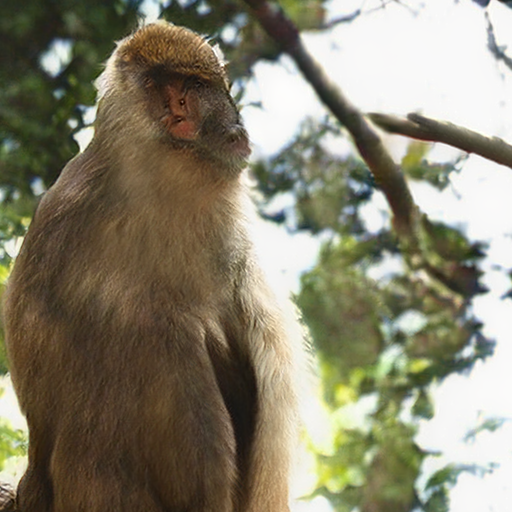

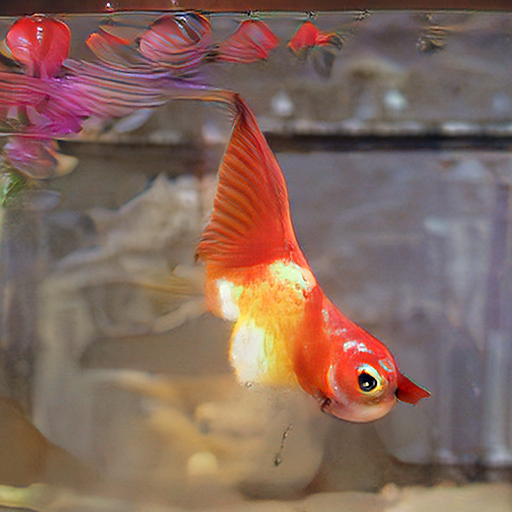

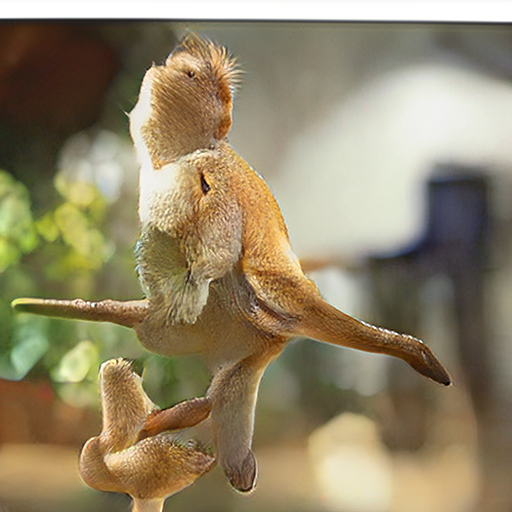

In [7]:
caio = G.synthesis(w_stds1, noise_mode='const')
display(TF.to_pil_image(tf(caio)[0]))
caio = G.synthesis(w_stds2, noise_mode='const')
display(TF.to_pil_image(tf(caio)[0]))
caio = G.synthesis(w_stds3, noise_mode='const')
display(TF.to_pil_image(tf(caio)[0]))